In [1]:
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

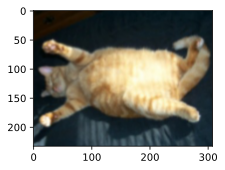

In [4]:
d2l.set_figsize()
img = d2l.Image.open('images/cat1.jpg')
d2l.plt.imshow(img)

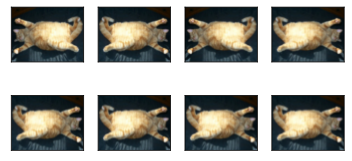

In [11]:
# 大多数图像增广方法都具有一定的随机性。为了便于观察图像增广的效果，我们下面定义辅助函数apply。 此函数在输入图像img上多次运行图像增广方法aug并显示所有结果。
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)
'''
左右翻转图像通常不会改变对象的类别。这是最早且最广泛使用的图像增广方法之一。 接下来，我们使用transforms模块来创建RandomFlipLeftRight实例，这样就各有50%的几率使图像向左或向右翻转。
'''
apply(img, torchvision.transforms.RandomHorizontalFlip())

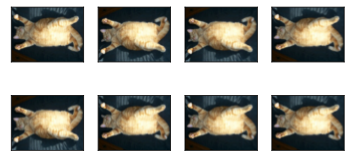

In [12]:
'''
上下翻转图像不如左右图像翻转那样常用。但是，至少对于这个示例图像，上下翻转不会妨碍识别。接下来，我们创建一个RandomFlipTopBottom实例，使图像各有50%的几率向上或向下翻转。
'''
apply(img, torchvision.transforms.RandomVerticalFlip())

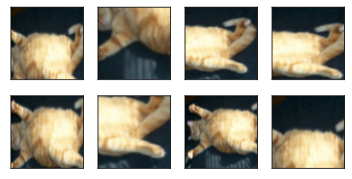

In [13]:
'''
下面的代码将随机裁剪一个面积为原始面积10%到100%的区域，该区域的宽高比从0.5～2之间随机取值。 然后，区域的宽度和高度都被缩放到200像素。 在本节中（除非另有说明），a和b之间的随机数指的是在区间[a, b]中通过均匀采样获得的连续值。
'''
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2)
)
apply(img, shape_aug)

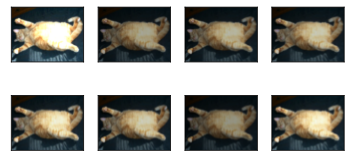

In [14]:
'''
随机更改图像的亮度，随机值为原始图像的50%（1-0.5）到150%（1+0.5）之间。
'''
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, saturation=0, contrast=0, hue=0))

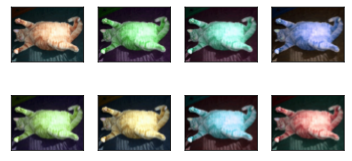

In [16]:
'''
随机更改图像的色调
'''
apply(img, torchvision.transforms.ColorJitter(brightness=0, saturation=0, contrast=0, hue=0.5))

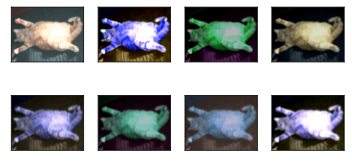

In [17]:
'''
同时更改
'''
apply(img, torchvision.transforms.ColorJitter(brightness=0.5, saturation=0.5, contrast=0.5, hue=0.5))

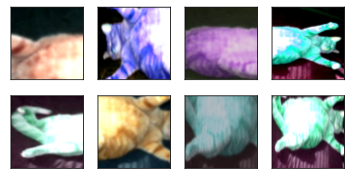

In [18]:
'''
在实践中，我们将结合多种图像增广方法。比如，我们可以通过使用一个Compose实例来综合上面定义的不同的图像增广方法，并将它们应用到每个图像。
'''
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ColorJitter(brightness=0.5, saturation=0.5, contrast=0.5, hue=0.5),
     torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))]
)
apply(img, augs)

### 使用图像增广进行训练


Extracting data\cifar-10-python.tar.gz to data


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000192737C1278>,
      dtype=object)

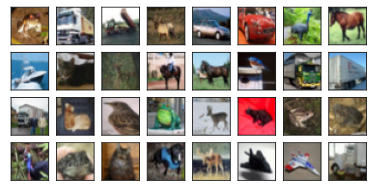

In [20]:
'''
让我们使用图像增广来训练模型。 这里，我们使用CIFAR-10数据集，而不是我们之前使用的Fashion-MNIST数据集。 这是因为Fashion-MNIST数据集中对象的位置和大小已被规范化，而CIFAR-10数据集中对象的颜色和大小差异更明显。 CIFAR-10数据集中的前32个训练图像如下所示。
'''
all_images = torchvision.datasets.CIFAR10(train=True, root="data", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

### 1.为了在预测过程中得到确切的结果，我们通常对训练样本只进行图像增广，且在预测过程中不使用随机操作的图像增广
### 2.在这里，我们只使用最简单的随机左右翻转。
### 3.此外，我们使用ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1。

In [21]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

### 接下来，我们定义一个辅助函数，以便于读取图像和应用图像增广。PyTorch数据集提供的transform参数应用图像增广来转化图像

In [22]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(train=is_train, root="data", download=True, transform=augs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train,
                                             num_workers=d2l.get_dataloader_workers())
    return dataloader

## 多GPU训练

In [23]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    trainer_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return trainer_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train_acc {metric[1] / metric[3]:.3f}, test_acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on'
          f'{str(devices)}')

In [24]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)
def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduce='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

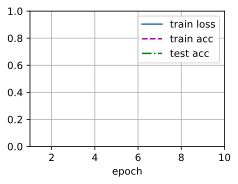

In [ ]:
train_with_data_aug(train_augs, test_augs, net)